Purpose: The crucial first step of any analysis. Load the raw data and explore it.

Content: Generate descriptive statistics, visualize distributions of symptoms, identify the most common foods, and look for any obvious initial patterns.

import all proper libs

In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter

config for styling of plot

In [17]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

load data using try/except

In [18]:
try:
    df_user = pd.read_csv("data/raw/user.csv")
    df_meals = pd.read_csv("data/raw/meals.csv")
    df_symptoms = pd.read_csv("data/raw/symptoms.csv")
    print("All data files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure you have run the '0_data_generation.ipynb' notebook first.")


All data files loaded successfully!


Convert Timestamps -> This is a critical step for any time-series analysis.

In [19]:
df_meals['timestamp'] = pd.to_datetime(df_meals['timestamp'])
df_symptoms['timestamp'] = pd.to_datetime(df_symptoms['timestamp'])

Since we have only one user, this section is straightforward. We'll simply display their demographic information to establish the context for our analysis

In [20]:
# Display user info in a readable format
user_info = df_user.iloc[0]
print("--- Analyzing Data For ---")
print(f"User ID: {user_info['user_id']}")
print(f"Age: {user_info['age']}")
print(f"Gender: {user_info['gender']}")
print(f"Diagnosis Date: {user_info['diagnosis_date']}")
print("--------------------------")

--- Analyzing Data For ---
User ID: user_123
Age: 32
Gender: Female
Diagnosis Date: 2021-08-16
--------------------------


##### Meal Analysis
Here, we'll explore the user's dietary patterns. We want to answer questions like:
- What types of meals are logged most often?
- What are the most frequently consumed foods and food categories (tags)?
- Are there any patterns in meal logging across the week?

meal type distribution - i guess it makes sense to all be equal since we do iterate through

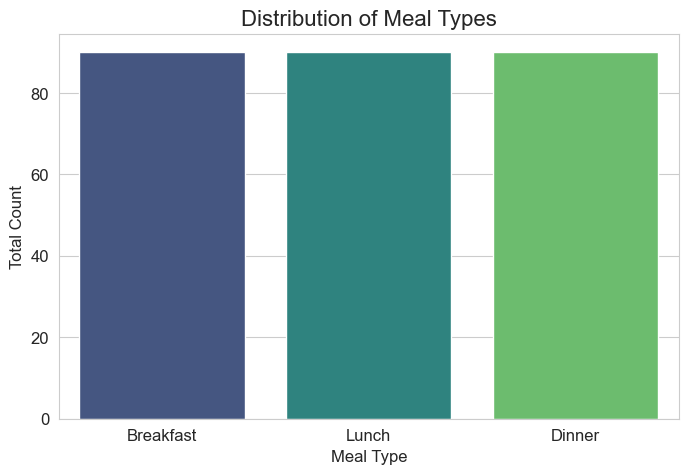

In [21]:
# --- Meal Type Distribution ---
plt.figure(figsize=(8, 5))
meal_type_counts = df_meals['meal_type'].value_counts()
sns.barplot(x=meal_type_counts.index, y=meal_type_counts.values, palette="viridis", hue=meal_type_counts.index, dodge=False)
plt.title('Distribution of Meal Types', fontsize=16)
plt.ylabel('Total Count')
plt.xlabel('Meal Type')
plt.show()

Top 10 Most Eaten Foods 

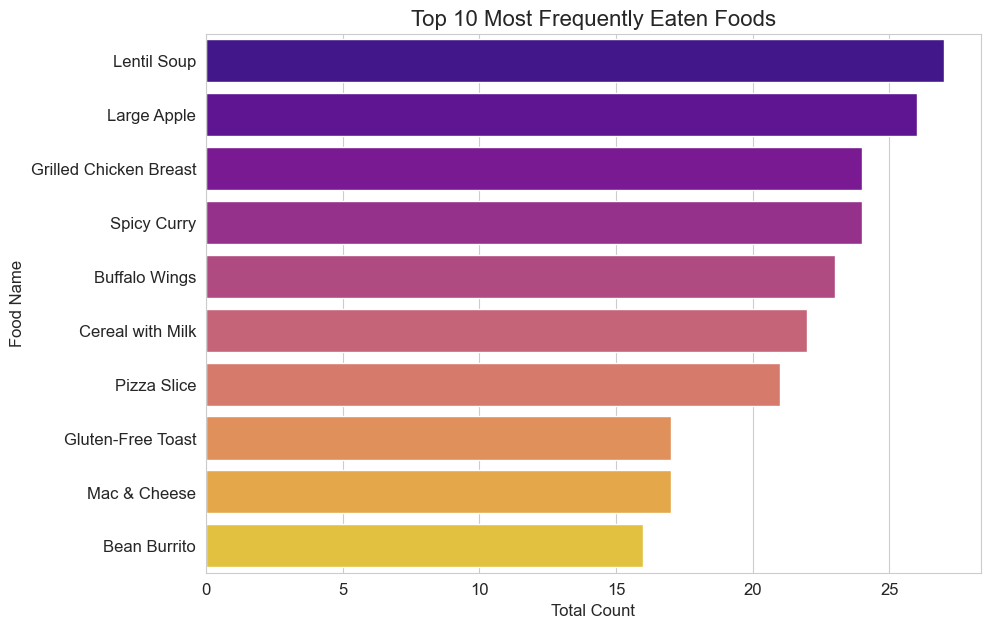

In [22]:
plt.figure(figsize=(10, 7))
top_foods = df_meals['food_name'].value_counts().nlargest(10)
sns.barplot(y=top_foods.index, x=top_foods.values, palette='plasma', hue=top_foods.index, dodge=False)
plt.title('Top 10 Most Frequently Eaten Foods', fontsize=16)
plt.xlabel('Total Count')
plt.ylabel('Food Name')
plt.show()

#### Most Common Food Tags:
- Thought Process: The 'food_tags' column is a string of comma-separated values.
- To analyze it, we need to split these strings, collect all the individual tags, and then count the frequency of each tag.

Split tags and flatten the list

In [23]:
all_tags = df_meals['food_tags'].str.split(', ').sum()

Count the frequency of each tag

In [24]:
tag_counts = Counter(all_tags)
df_tags = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values('Count', ascending=False)

plot top 10

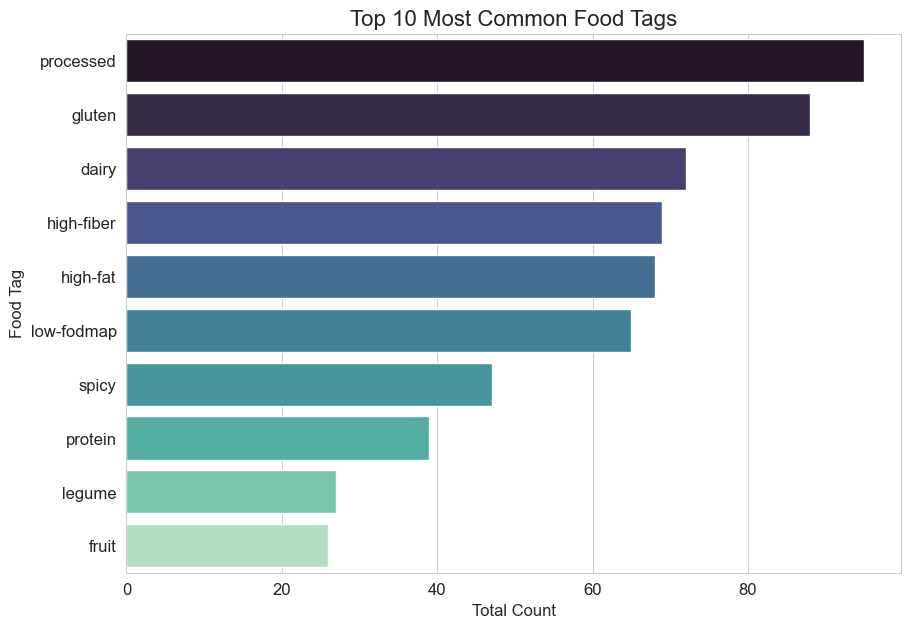

In [25]:
plt.figure(figsize=(10, 7))
sns.barplot(data=df_tags.head(10), y='Tag', x='Count', palette='mako', hue='Tag', dodge=False)
plt.title('Top 10 Most Common Food Tags', fontsize=16)
plt.xlabel('Total Count')
plt.ylabel('Food Tag')
plt.show()

-------

#### Symptom Analysis 
Now let's analyze the user's reported symptoms. We aim to understand:
- What are the most common symptoms?
- How severe are these symptoms typically?
- Is there a pattern to when symptoms are reported?

--- Symptom Frequency ---

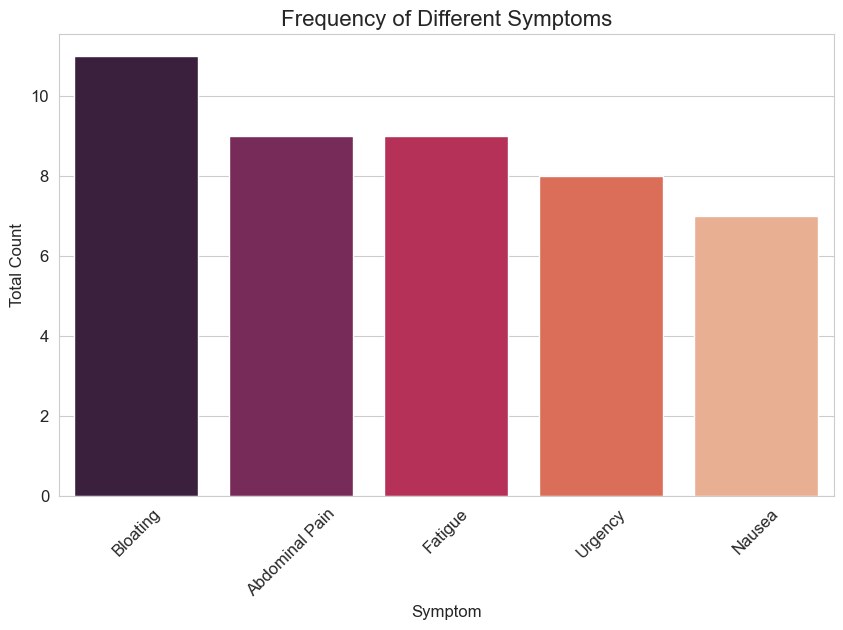

In [26]:
plt.figure(figsize=(10, 6))
symptom_counts = df_symptoms['symptom'].value_counts()
sns.barplot(x=symptom_counts.index, y=symptom_counts.values, palette='rocket', hue=symptom_counts.index, dodge=False)
plt.title('Frequency of Different Symptoms', fontsize=16)
plt.ylabel('Total Count')
plt.xlabel('Symptom')
plt.xticks(rotation=45)
plt.show()

--- Symptom Severity Distribution ---

- the line indicates the average severity

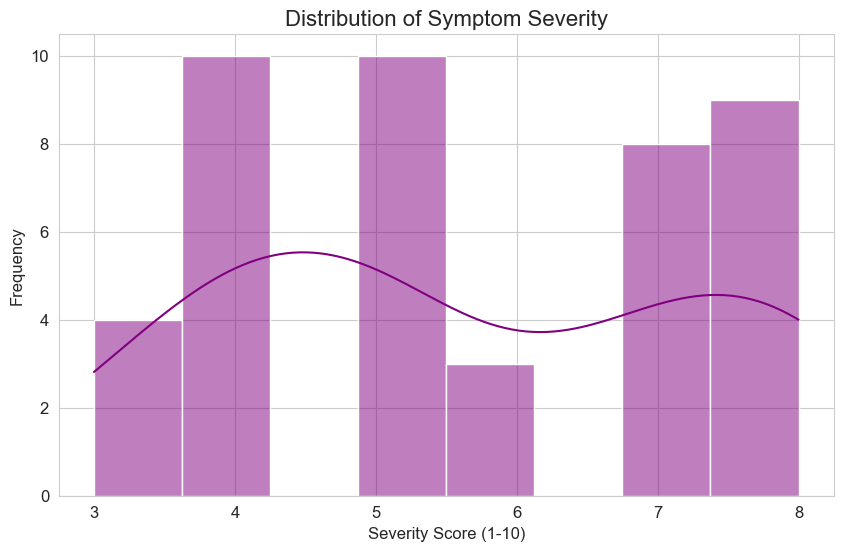

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(df_symptoms['severity'], bins=8, kde=True, color='purple')
plt.title('Distribution of Symptom Severity', fontsize=16)
plt.xlabel('Severity Score (1-10)')
plt.ylabel('Frequency')
plt.show()

------

#### Combined Timeline Analysis 
Thought Process: The most powerful part of an EDA for this kind of data is to see everything on a single timeline. Even though we generated the data independently, a visual inspection is what a real user or researcher would do first to spot potential correlations.

We will use Plotly for an interactive visualization. This allows us to zoom into specific weeks or days and hover over points to get more details.

We will plot:
- Symptoms: As large diamond-shaped markers.
- Meals: As smaller circle markers.

This will help us visually answer: "Do symptoms tend to appear after certain types of meals?"

In [ ]:
# Let's focus on a specific month to make the plot readable.
# We'll choose the first month of data.
start_period = df_meals['timestamp'].min()
end_period = start_period + pd.Timedelta(days=30)

make subset of dfs by first month

In [ ]:
df_meals_subset = df_meals[(df_meals['timestamp'] >= start_period) & (df_meals['timestamp'] <= end_period)]
df_symptoms_subset = df_symptoms[(df_symptoms['timestamp'] >= start_period) & (df_symptoms['timestamp'] <= end_period)]

In [31]:
# --- Create the base figure with symptoms ---
fig = px.scatter(
    df_symptoms_subset,
    x='timestamp',
    y='severity',
    size='severity',
    color='symptom',
    symbol_sequence=['diamond'],
    hover_data=['symptom', 'severity'],
    title='Interactive Timeline of Meals & Symptoms (First Month)'
)

In [32]:
# --- Create a separate figure for meals to grab its traces ---
meal_fig = px.scatter(
    df_meals_subset,
    x='timestamp',
    y=[2] * len(df_meals_subset), # Plot meals at a constant y-level
    color='meal_type',
    symbol='meal_type',
    hover_data=['food_name', 'food_tags']
)


In [33]:
# --- Loop through each trace in the meal figure and add it to the main figure ---
for trace in meal_fig.data:
    fig.add_trace(trace)


# --- Customize the layout ---
fig.update_layout(
    xaxis_title='Date & Time',
    yaxis_title='Symptom Severity (Meals at bottom)',
    legend_title='Event Type',
    height=600
)

fig.show()

-------

### EDA Conclusion & Next Steps

Based on our analysis of this synthetic user's data:
- Dietary Habits: The user consumes a varied diet. The most common food tags are processed, gluten, and dairy suggesting a typical Western diet.

- Symptom Profile: The most frequently reported symptom is Fatigue, followed by Abdominal Pain and Bloating. Symptom severity is most often in the mid-range (4-7).

- Visual Timeline: The interactive timeline provides a powerful tool for visual inspection. While our current data has no built-in correlation, in a real-world scenario, this chart would be the primary tool for a user to spot patterns like "It seems like every time I have X food, I feel Y symptom a few hours later."

Next Steps: With this foundational understanding, we can proceed to the next phases. Phase 1 would involve taking small windows of this data (e.g., a few days) and feeding it to an LLM to generate initial, research-based insights.